In [17]:
from_date = '20230405'
to_date = '20230405'
searching_word = 'finance OR banking OR investment OR economy OR sustainability'

In [18]:
import os
import pickle
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import numpy

import re
import requests 
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
import chromedriver_autoinstaller
import subprocess
import shutil
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from newspaper import Article

import nltk
from keybert import KeyBERT

from collections import Counter
from dateutil.relativedelta import relativedelta
import logging
import numpy as np

# 워드 클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from wordcloud import (WordCloud, get_single_color_func)

In [19]:
# 0. 환경설정 및 세팅
try:
    shutil.rmtree(r"c:\chrometemp")  #쿠키 / 캐쉬파일 삭제
except FileNotFoundError:
    pass

subprocess.Popen(r'C:\Program Files\Google\Chrome\Application\chrome.exe --remote-debugging-port=9222 --user-data-dir="C:\chrometemp"') # 디버거 크롬 구동


option = Options()
option.add_experimental_option("debuggerAddress", "127.0.0.1:9222")

chrome_ver = chromedriver_autoinstaller.get_chrome_version().split('.')[0]
try:
    driver = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe', options=option)
except:
    chromedriver_autoinstaller.install(True)
    driver = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe', options=option)
driver.implicitly_wait(10)
cwd = os.getcwd()
main_path = cwd + '/' + searching_word

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(main_path)
createFolder(main_path + '/' + 'url')
createFolder(main_path + '/' + 'news_backup')
createFolder(main_path + '/' + 'news')
createFolder(main_path + '/' + 'keyword')

C:\Users\NH\AppData\Local\Temp\ipykernel_9348\290069735.py:15: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe', options=option)


In [20]:
# 1 키워드 검색 뉴스 url 수집
def page2url(searching_word,date):
    searching_word = '{}'.format(searching_word)
    urls = []
    for start in range(0, 360, 10): ### 하루에 관련 기사를 최대 얼마나 뽑을지 설정.
        main_url = 'https://www.google.co.kr/search?q={}&tbs=cdr:1,cd_min:{},cd_max:{}&tbm=nws&ei=dPP-Yu_eCJLL-Qb55bvQDA&start={}&sa=N&ved=2ahUKEwjv6Lvy69H5AhWSZd4KHfnyDso4ChDy0wN6BAgBEDk&biw=1536&bih=754&dpr=1.25'.format(searching_word,date,date,start)
        driver.get(url=main_url)
        elements = driver.find_elements(By.TAG_NAME, 'a')
        lnks = []
        for lnk in elements:
            lnk = str(lnk.get_attribute('href'))
            if 'google' not in lnk and lnk != 'None':
                lnks.append(lnk)
        if len(lnks) == 0:
            print(date, ' Url 수집 완료')
            break
        urls.extend(lnks)
        rand_value =random.uniform(4, 10)
        time.sleep(rand_value)
        
    return urls

datelist = pd.date_range(start=from_date, end=to_date).tolist()
dtlst = []
for d_t in datelist:
    d_t = str(d_t)[0:-9]
    d = datetime.strptime(d_t, '%Y-%m-%d')
    d = d.strftime('%m/%d/%Y')
    d = d[0].replace('0','') + d[1:]
    d = d[:-7] + d[-7].replace('0','') + d[-6:]
    dtlst.append(d)
    
    
Urls = dict()
for date in tqdm(dtlst):
    print(date,'Url 수집 시작')
    urls = page2url(searching_word,date)
    Urls[date] = urls
    
name = "Urls{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')

with open(main_path + '/' + 'url/' + name,'wb') as f:
    pickle.dump(Urls,f)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

4/5/2023 Url 수집 시작


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:35<00:00, 215.60s/it]

4/5/2023  Url 수집 완료


In [21]:
# 2  수집된 url로 news 크롤링 
name = "Urls{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'url/' + name, 'rb') as f:
    data = pickle.load(f)

# start = 0
for date in list(data):
    print(date, '크롤링 시작')
    cnt = 0
    tmp = []
    urls = []
    for idx,url in tqdm(enumerate(data[date])):
        try:
            article = Article(url)
            article.download()
            article.parse()
            v = article.text
            tmp.append(v)
            urls.append(url)
            cnt += 1
        except:
            pass
            tmp.append("null")
            urls.append(url)
            print(url)
    print("총 {}건 중 {} 건 크롤링 성공".format(idx+1,cnt))
    data[date] = [tmp,[urls]]
    date = date.replace('/','-')
    with open(main_path + '/' + 'news_backup/' + 'news-' + date + '.pickle','wb') as f:
        pickle.dump(data,f)
    print(date,' 크롤링 완료')
    
data = pd.DataFrame(data).T

data = data.rename({0:"news",1:"url"},axis= 1)

name = "News{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')

with open(main_path + '/' + 'news/' + name,'wb') as f:
    pickle.dump(data,f)

4/5/2023 크롤링 시작


7it [00:07,  1.16it/s]

https://simpleflying.com/cathay-pacific-sustainability-report/
https://www.wsj.com/articles/at-least-10-000-foreign-companies-to-be-hit-by-eu-sustainability-rules-307a1406


11it [00:15,  1.85s/it]

https://www.forbes.com/sites/jonathanponciano/2023/04/05/economy-is-unwell-job-growth-unexpectedly-slows-as-employers-scale-back-wages-and-freeze-hiring/


22it [00:38,  3.32s/it]

https://www.nfuonline.com/updates-and-information/new-defra-plan-offers-additional-water-investment-for-farmers/


61it [01:33,  1.13s/it]

https://www.forbes.com/sites/sap/2023/04/05/easter-supply-chain-demand-and-sustainability-concerns-keep-businesses-hopping/


68it [01:40,  1.12it/s]

https://www.citywindsor.ca/Newsroom/Pages/Windsor-Celebrates-Magna-Investment.aspx


75it [01:49,  1.30s/it]

https://www.forbes.com/sites/katevitasek/2023/04/05/challenging-traditional-investments-co-creating-impact-in-the-investment-space/


97it [02:24,  1.24s/it]

https://www.forbes.com/sites/walterloeb/2023/04/05/why-some-brands-thrive-in-a-tough-economy--and-others-do-not/


117it [02:49,  1.01it/s]

https://www.cooley.com/news/insight/2023/2023-04-05-banking-sector-events-may-affect-qualified-small-business-stock-treatment


132it [03:03,  1.30it/s]

https://www.thelocal.de/20230405/why-the-german-economy-is-expected-to-grow-in-2023


134it [03:04,  1.89it/s]

https://www.pymnts.com/connectedeconomy/2023/stripe-confident-web-economy-despite-significant-slowing-growth/


143it [03:18,  1.45s/it]

https://www.wsj.com/articles/new-york-finance-regulator-says-signature-banks-closure-not-related-to-crypto-120926ec


147it [03:21,  1.22it/s]

https://www.sdxcentral.com/articles/news/ibm-z16-linuxone-servers-target-edge-computing-sustainable-design/2023/04/


162it [03:37,  1.25it/s]

https://financialpost.com/pmn/press-releases-pmn/business-wire-news-releases-pmn/assents-new-2022-sustainability-report-demonstrates-progress-toward-deep-sustainability


169it [03:42,  2.39it/s]

https://www.forbes.com/sites/daneberhart/2023/04/05/banking-crisis-adds-to-shale-industry-pessimism/
https://www.barrons.com/articles/german-economy-to-grow-0-3-in-2023-economic-institutes-975ce29c


170it [03:42,  2.02it/s]

https://wineindustryadvisor.com/2023/04/05/paving-the-way-to-sustainability-in-the-wine-industry


180it [03:57,  1.61s/it]

https://www.barrons.com/advisor/articles/pennies-steamroller-investment-grade-bonds-59764d0f


187it [04:00,  1.64it/s]

https://www.theedgesingapore.com/news/sustainability/are-singaporean-workers-ready-green-economy


195it [04:12,  1.21s/it]

https://www.ssonetwork.com/finance-transformation/webinars/generative-ai-finance


202it [04:19,  1.29it/s]

https://www.connectcre.com/stories/galvanize-launches-sustainable-real-estate-investment-plan/
https://www.datacenterdynamics.com/en/news/vantage-forms-new-investment-consortium-in-emea/


209it [04:29,  1.00it/s]

https://www.forbes.com/sites/jamielsheikh/2023/04/05/the-chatgpt-of-finance-is-here-bloomberg-is-combining-ai-and-fintech/
https://www.pymnts.com/news/partnerships-acquisitions/2023/finfit-salary-finance-merge-integrate-financial-wellness-offerings/


222it [04:52,  2.34s/it]

https://developmentbank.wales/news-and-events/development-bank-wales-commits-principles-responsible-investment


243it [05:24,  2.98s/it]

https://timesofindia.indiatimes.com/blogs/desires-of-a-modern-indian/digital-economy-has-a-new-global-captain-india/


252it [05:35,  1.24s/it]

https://www.forbes.com/sites/laurasmythe/2023/04/05/forbes-daily-banking-repercussions/


257it [05:38,  1.38it/s]

https://www.forbes.com/sites/forbesfinancecouncil/2023/04/05/breaking-the-glass-ceiling-5-strategies-women-can-use-to-advance-in-finance/
https://www.mining.com/ancient-enzyme-may-play-key-role-in-producing-hydrogen-for-green-economy/


261it [05:43,  1.04it/s]

https://www.esi-africa.com/industry-sectors/research-and-development/east-africa-undp-backs-finance-models-for-clean-energy-solutions/


263it [05:47,  1.32s/it]

총 263건 중 233 건 크롤링 성공
4-5-2023  크롤링 완료


In [22]:
# 3. 뉴스기사에서 키워드 추출

def doc2key(cleaned_content):
    
    kw_model = KeyBERT(model='all-MiniLM-L6-v2')
    
    n2_kwd = kw_model.extract_keywords(cleaned_content, keyphrase_ngram_range=(2, 2), stop_words='english',
                                  use_mmr=True, diversity=0.7, top_n=1)

    n1_kwd = kw_model.extract_keywords(cleaned_content, keyphrase_ngram_range=(1, 1), stop_words='english',
                                  use_mmr=True, diversity=0.7, top_n=20)
    for idx,i in enumerate(n2_kwd):
        n2_kwd[idx] = i[0]
    for idx,i in enumerate(n1_kwd):
        n1_kwd[idx] = i[0]  

    n1_kwd.extend(n2_kwd)
    kwd = n1_kwd
    return kwd

def makeKeywordLsit(data,nn_jj = False):
    kwd_list = []
    for docs in tqdm(data['news']):
        kwds = []
        for doc in tqdm(docs):
            try:
                cleaned_content = re.sub(r'[^\.\?\!\w\d\s]','',doc) # 문장단위로 끊기
                cleaned_content = cleaned_content.replace('\n',' ')
                cleaned_content = cleaned_content.lower()
                kwd = doc2key(cleaned_content)
                if nn_jj == True:
                    tokens_pos = nltk.pos_tag(kwd)
                    kwd_nn_jj = []
                    for word, pos in tokens_pos:
                        if 'NN' in pos or 'JJ' in pos:
                            kwd_nn_jj.append(word)
                    kwds.append(kwd_nn_jj)
                else:
                    kwds.append(kwd)
            except:
                print(doc)
        kwd_list.append(kwds)
    return kwd_list

# 데이터불러오기

name = "News{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')

with open(main_path + '/' + 'news/' + name, 'rb') as f:
    data = pickle.load(f)

# 전처리
data = data.reset_index()
data = data.rename({"index":"date"},axis = 1)

idx = []
for x in data['date']:
    tmp = x.split('/')
    if len(tmp[0]) == 1:
        tmp[0] = '0'+tmp[0]
    if len(tmp[1]) == 1:
        tmp[1] = '0'+tmp[1]
    tmp = tmp[2] + tmp[0] + tmp[1]
    idx.append(''.join(tmp))
    
data['date'] = idx
data = data.rename({'date':'일자'},axis = 1)

# 키워드 추출
kwd_list = makeKeywordLsit(data, nn_jj = True)

# 데이터 추가
data['키워드'] = kwd_list

# 저장
name = "Keyword{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'keyword/' + name,'wb') as f:
    pickle.dump(data,f)

 24%|███████████████████▋                                                             | 64/263 [01:01<02:52,  1.15it/s]


 49%|███████████████████████████████████████▌                                        | 130/263 [02:27<02:48,  1.27s/it]


 75%|███████████████████████████████████████████████████████████▌                    | 196/263 [04:33<01:40,  1.50s/it]


100%|███████████████████████████████████████████████████████████████████████████████▋| 262/263 [06:38<00:01,  1.37s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:39<00:00, 399.71s/it]


In [23]:
data

일자                                               news  \
0  20230405  [Sport must address its key challenges now and...   

                                                 url  \
0  [[https://www.sportanddev.org/latest/news/over...   

                                                 키워드  
0  [[sports, emissions, scarcity, temperatures, i...

In [24]:
# 4. 추출된 키워드 전처리
def get_slop(df2,from_date,to_date):
    datelist = pd.date_range(start=from_date, end=to_date, freq = 'M').tolist()
    dtlst = []
    df = df2.copy()
    for d_t in datelist:
        d_t = str(d_t)[0:-9]
        d = datetime.strptime(d_t, '%Y-%m-%d')
        d = d.strftime('%Y%m')
        dtlst.append(d)
    for dt in dtlst:
        df[dt] = df[dt][:-1]*10000 / df[dt][-1]
    from scipy import stats

    x = [x + 1for x in range(0,len(dtlst))]

    slopes = []
    for i in list(df.values):
        y = i[:-2]
        slope, intercept, r, p, std_err = stats.linregress(x, y)
        slopes.append(slope)
    df['slope'] = slopes
    return df

def data_pro(data,from_date,to_date):

    df = data[['일자','키워드']]
    df['일자'] = [str(x)[0:6] for x in df['일자']] 
    # Input string
    date_str = to_date

    # Convert the string to a datetime object
    date_obj = datetime.strptime(date_str, '%Y%m%d')

    # Add one month to the datetime object
    new_date_obj = date_obj + relativedelta(months=1)

    # Convert the result back to a string
    new_date_str = new_date_obj.strftime('%Y%m%d')
    to_date = new_date_str
    datelist = pd.date_range(start=from_date, end=to_date, freq = 'M').tolist()
    dtlst = []

    for d_t in datelist:
        d_t = str(d_t)[0:-9]
        d = datetime.strptime(d_t, '%Y-%m-%d')
        d = d.strftime('%Y%m')
        dtlst.append(d)

    # 키워드 사전 
    keyword_vocab = []
    for i in df['키워드']:
        keyword_vocab.extend(i)
    keyword_vocab = list(set(keyword_vocab))

    # 월별 카운팅 후 병합 # 병합하는 방식 수정해야함. 한달만 카운트는 현재 불가.

    tmp_df_list = []
    for dt in dtlst:
        tmp = []
        for i in df[df['일자']== dt]['키워드']:
            tmp.extend(i)
        tmp_df = pd.DataFrame(pd.Series(Counter(tmp)))
        tmp_df = tmp_df.reset_index()
        tmp_df = tmp_df.rename(columns = {0:'cnt','index':'keyword'})
        tmp_df_list.append(tmp_df)

    if len(tmp_df_list) > 1:
        df = tmp_df_list[0].merge(tmp_df_list[1], on = 'keyword', how = 'outer')
        for i in range(len(tmp_df_list)):
            if i > 1:
                df = df.merge(tmp_df_list[i], on = 'keyword', how = 'outer')
        col = ['keyword'] + dtlst
        df.columns = col
    elif len(tmp_df_list) == 1:
        df = tmp_df_list[0]
        col = ['keyword'] + dtlst
        df.columns = col

    # 합산 값 만들기
    df.index = df['keyword']
    df = df.drop('keyword', axis = 1)
    df['tot_cnt'] = df.sum(axis = 1)
    df = df.T
    df['year_cnt'] = df.sum(axis = 1)
    df = df.T
    df

    # 결측치 처리
    df =df.fillna(0)
    return df

def DataEn(searching_word,from_date,to_date,slope = True):
    cwd = os.getcwd()
    main_path = cwd + '/' + searching_word
    name = "Keyword{}-{}.pickle".format(from_date,to_date)
    name = name.replace('/','.')
    with open(main_path + '/' + 'keyword/' + name, 'rb') as f:
        data_e = pickle.load(f)
      
    result = data_e[['일자','키워드']].explode('키워드').reset_index(drop=True)
    data_e = result
    print("총 기사 건 수 : " + str(len(data_e['키워드'])))
    df_e = data_pro(data_e,from_date,to_date)
    df_e.to_csv(cwd +'/' + searching_word + '/'+ 'Monthly_Count_Keyword {}-{}.csv'.format(from_date,to_date),encoding="utf-8-sig")
    
    if slope == True:
        df_es = get_slop(df_e,from_date,to_date)
        df_es.to_csv(cwd +'/' + searching_word + '/'+ 'Efficient_OLS_Keyword {}-{}.csv'.format(from_date,to_date),encoding="utf-8-sig")
        
DataEn(searching_word,from_date,to_date,slope = False) # 한달이내는 기울기를 만들 수 없음.

총 기사 건 수 : 263


In [25]:
# 5. 워드클라우드 그리기

def DrawPointColoredWC(tags,title,cwd,searching_word, drop_list=[], color = '#00ff00', pointed_list=[]):
    color_to_words = {
        color : pointed_list
    }

    use_tags = tags.drop(drop_list, errors = 'ignore')
    wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)

    default_color = 'black'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    cloud = wc.generate_from_frequencies(dict(use_tags))
    wc.recolor(color_func=grouped_color_func)

    figure(dpi=1200)
    figure(figsize=[12,8])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(cwd + '/' + searching_word + '/'+ title + ' 강조'+'.pdf')
    plt.show()
    
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)
    
# 데이터 전처리
cwd = os.getcwd()
path = cwd +'/' + searching_word + '/raw'

df_cnt = pd.read_csv(cwd +'/' + searching_word + '/'+ 'Monthly_Count_Keyword {}-{}.csv'.format(from_date,to_date),index_col = 'keyword')

main_path = cwd + '/' + searching_word
name = "Keyword{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'keyword/' + name, 'rb') as f:
    data_e = pickle.load(f)
    
result = data_e[['일자','url']].explode('url').reset_index(drop=True)
url_long_data = result.explode('url').reset_index(drop=True)

keyword_long_data = data_e[['일자','키워드']].explode('키워드').reset_index(drop=True)

print('{}로 검색하여 {}부터 {}까지 {} 건의 기사를 인용했습니다.'.format(searching_word,from_date,to_date,len(url_long_data )))

finance OR banking OR investment OR economy OR sustainability로 검색하여 20230405부터 20230405까지 263 건의 기사를 인용했습니다.


In [26]:
# 최대 키워드 수, 지울 단어, 강조할 단어 지정
num_exp = 50
drop_list = [np.nan,'wednesday','december','today','monday','thomson','httpswww','sustainable','sustainability','review','service','supports','review terms','sure','information','reuters','policy','terms','theres','happen','cookies','content','javascript','average','sector','sectors','standards','trust','browser','supports javascript','did happen','loading information']
num = num_exp + len(drop_list)
color_to_words = {
    '#00ff00': []
}

20230405에서 20230405까지 키워드 출현 빈도 순 상위 50개 입니다


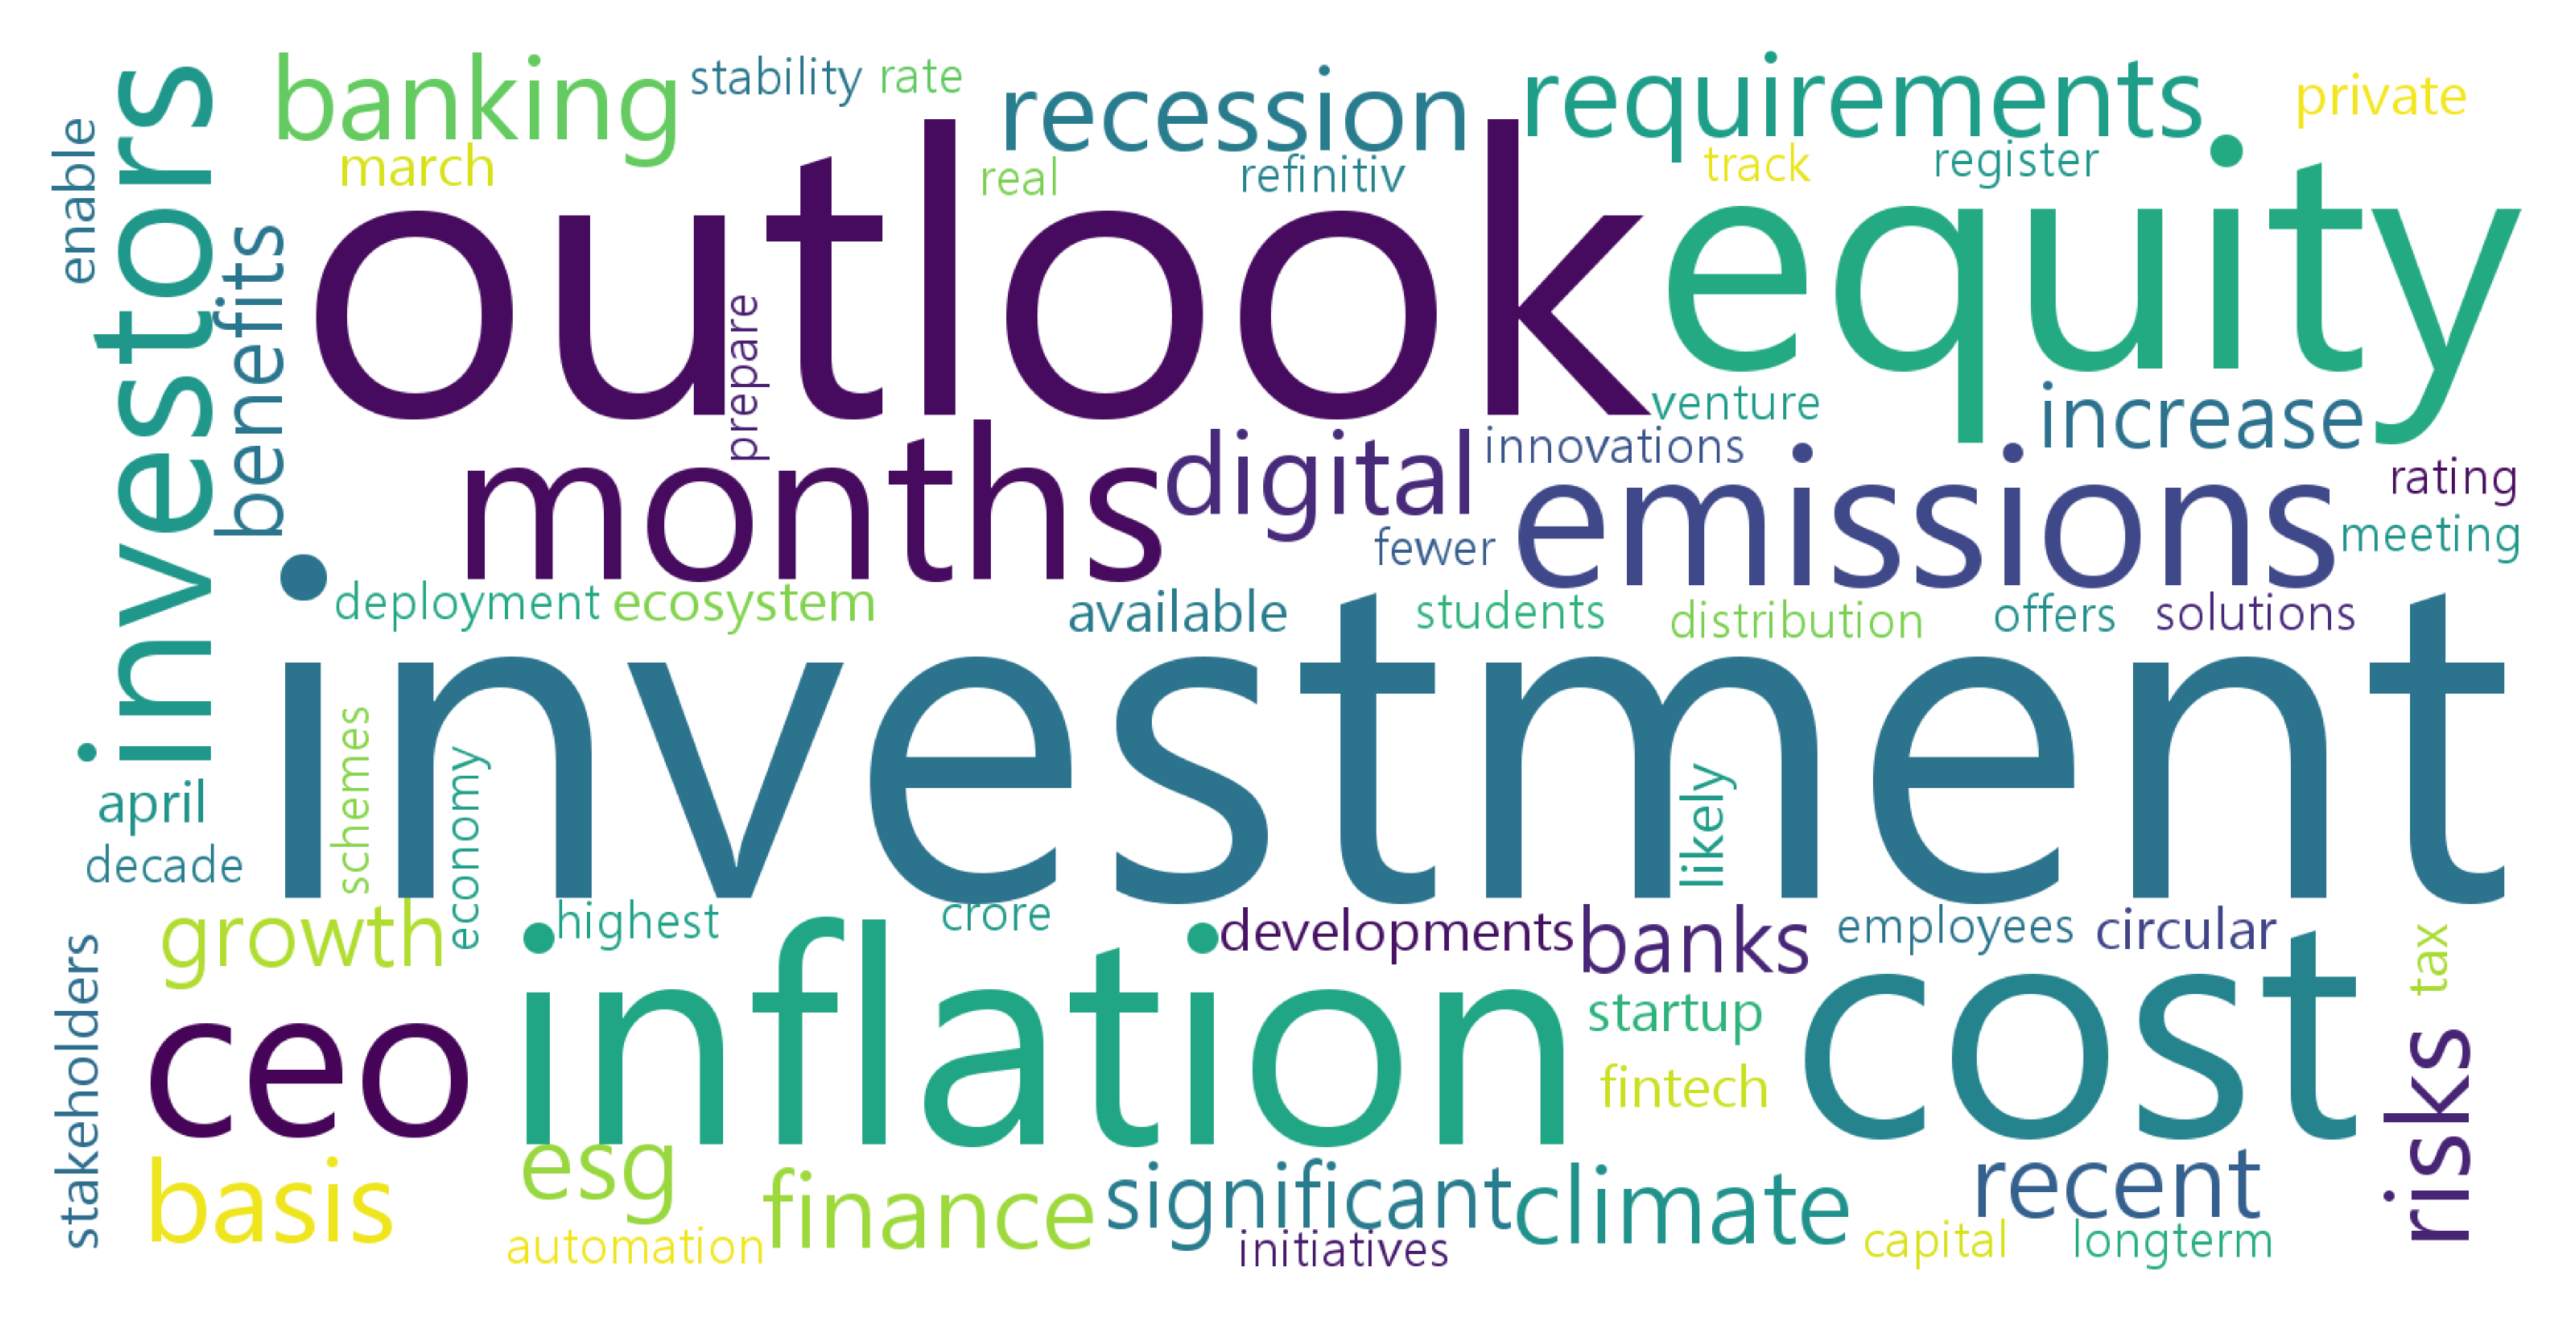

In [27]:
# 그림 그리기 및 저장
print('{}에서 {}까지 키워드 출현 빈도 순 상위 {}개 입니다'.format(from_date,to_date,num_exp))
tags = df_cnt.sort_values(by = 'tot_cnt', ascending = False)[1:num+1]['tot_cnt']
tags = tags.drop(drop_list, errors = 'ignore')
wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)
# default_color = 'black'
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)

cloud = wc.generate_from_frequencies(dict(tags))
# wc.recolor(color_func=grouped_color_func)

figure(dpi=1200)
title = '대상기간_최대출현_키워드_{}개'.format(str(num_exp))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + searching_word + '/'+ title + from_date + '.pdf')
plt.show()

In [28]:
keyword = 'savings'

tmp = []
for i in keyword_long_data['키워드']:
    if keyword in i:
        tmp.append(True)
    else:
        tmp.append(False)

for url in url_long_data[tmp]['url']:
    print(url)

https://www.ft.com/content/cb7e919a-f035-4e41-ad4a-6f066a497135
https://www.ft.com/content/b0865633-82f2-4a49-ae0e-3bc0d1087a31
